#### Preprocess the data

In [134]:
trajectories = pd.read_csv('density_points_full.csv') #read in trajectory data

In [135]:
#round up lat and lon to reduce model run time
trajectories['lat_round'] = round(trajectories['lat'],1)
trajectories['lon_round'] = round(trajectories['lon'],1)

trajectories = pd.DataFrame(trajectories.groupby(['lat_round','lon_round'])['mmsi'].count())

In [136]:
trajectories.reset_index(inplace=True)

In [137]:
coords = trajectories.as_matrix(columns=['lat_round','lon_round']) #set lat-lon coordinates for input into the model

/Users/colinbradley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [138]:
trajectories.shape

(967408, 3)

#### DBSCAN Model

Tests:

epsilon = 10, min_samples = 100
epsilon = 50, min_samples = 100
epsilon = 100, min_samples = 100

In [139]:
kms_per_radian = 6371.0088 #radians for haversine calculation
epsilon = 50 / kms_per_radian #number of KM converted to raidans

In [140]:
#initialize model
db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(coords),sample_weight=trajectories['mmsi'])

DBSCAN(algorithm='ball_tree', eps=0.007848050688613082, leaf_size=30,
       metric='haversine', metric_params=None, min_samples=100, n_jobs=None,
       p=None)

In [141]:
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 548


In [142]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters[:-1].map(get_centermost_point)

In [143]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [144]:
#world background for plots
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

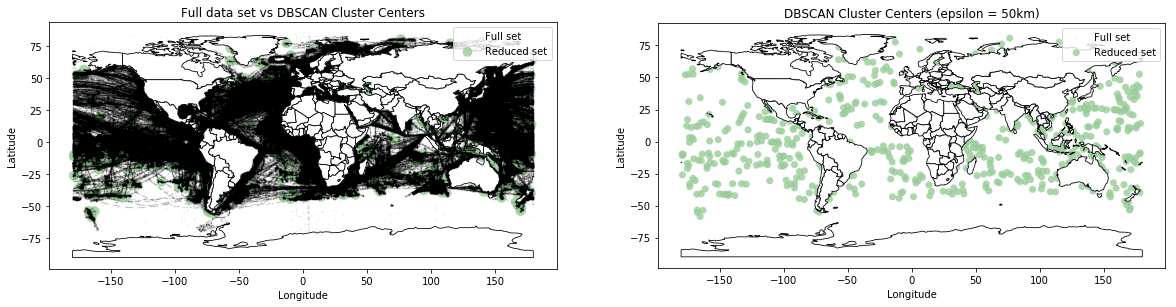

In [145]:
fig = plt.figure(figsize=[20, 20])

ax = fig.add_subplot(121)

rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.8, s=100)
df_scatter = ax.scatter(trajectories['lon_round'], trajectories['lat_round'], c='k', alpha=0.1, s=0.2)
ax.set_title('Full data set vs DBSCAN Cluster Centers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')

world.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)

ax1 = fig.add_subplot(122)

rs_scatter = ax1.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.8, s=50)
#df_scatter = ax.scatter(trajectories['lon_round'], trajectories['lat_round'], c='k', alpha=0.1, s=0.2)
ax1.set_title('DBSCAN Cluster Centers (epsilon = 50km)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')

world.plot(ax=ax1,color='white',edgecolor='black',linewidth=0.8)
plt.savefig('DBSCAN_50km.jpg')
plt.show()

In [146]:
trajectories = pd.merge(left=trajectories,right=pd.DataFrame(cluster_labels),left_index=True,right_index=True)

In [148]:
cluster_size = pd.DataFrame(trajectories.groupby([0])['mmsi'].sum())
cluster_intensity = pd.merge(left=rep_points,right=cluster_size,how='left',left_index=True,right_index=True)

In [150]:
cluster_intensity_tops = cluster_intensity.sort_values(by='mmsi',ascending=False)[:10]

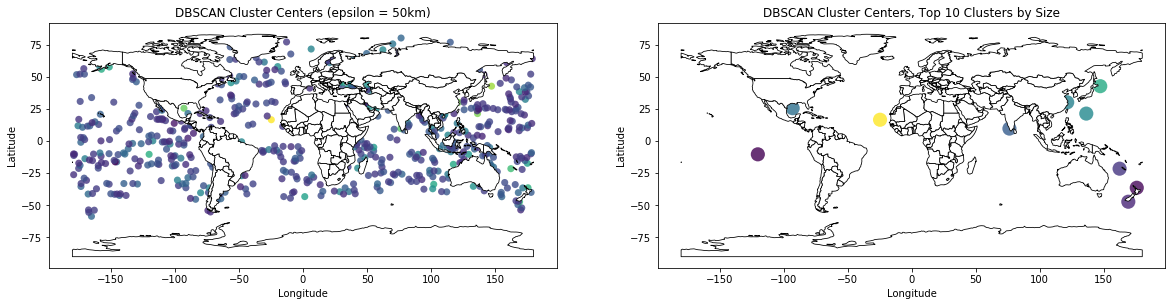

In [151]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121)

rs_scatter = ax.scatter(cluster_intensity['lon'], cluster_intensity['lat'], c=np.log(cluster_intensity['mmsi']), edgecolor='None', alpha=0.8, s=50)
#df_scatter = ax.scatter(trajectories['lon_round'], trajectories['lat_round'], c='k', alpha=0.1, s=0.2)
ax.set_title('DBSCAN Cluster Centers (epsilon = 50km)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

world.plot(ax=ax,color='white',edgecolor='black',linewidth=0.8)

ax1 = fig.add_subplot(122)
rs_scatter = ax1.scatter(cluster_intensity_tops['lon'], 
                        cluster_intensity_tops['lat'], c=np.log(cluster_intensity_tops['mmsi']), edgecolor='None', alpha=0.8, s=200)
#df_scatter = ax.scatter(trajectories['lon_round'], trajectories['lat_round'], c='k', alpha=0.1, s=0.2)
ax1.set_title('DBSCAN Cluster Centers, Top 10 Clusters by Size')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

world.plot(ax=ax1,color='white',edgecolor='black',linewidth=0.8)
plt.savefig('DBSCAN_cluster_intensity50.jpg')
plt.show()

### OPTICS Test

In [9]:
trajectories = pd.read_csv('density_points_full.csv') #read in trajectory data

In [10]:
#round up lat and lon for reducing data size
trajectories['lat_round'] = round(trajectories['lat'],0)
trajectories['lon_round'] = round(trajectories['lon'],0)

trajectories = pd.DataFrame(trajectories.groupby(['lat_round','lon_round'])['mmsi'].count())

In [11]:
trajectories.reset_index(inplace=True)

In [12]:
trajectories.shape

(28255, 3)

In [13]:
#set lat-lon coordinates for input into the model
coords = trajectories.as_matrix(columns=['lat_round','lon_round']) 

/Users/colinbradley/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [14]:
kms_per_radian = 6371.0088 #radians for haversine calculation
epsilon = 50 / kms_per_radian #number of KM converted to raidans

In [15]:
ops = OPTICS(eps=epsilon,min_samples=100,metric='haversine')
ops.fit(np.radians(coords))

OPTICS(algorithm='auto', cluster_method='xi', eps=0.007848050688613082,
       leaf_size=30, max_eps=inf, metric='haversine', metric_params=None,
       min_cluster_size=None, min_samples=100, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [ ]:
cluster_labels = ops.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))